In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph
from kpsn import fitting
from kpsn.models import util as model_util
from kpsn.io import alignment, features
from kpsn.fitting import em
from kpsn.io import utils as io_utils
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.io.armature import Armature
from kpsn.io.dataset import KeypointDataset, FeatureDataset
from kpsn import clouds
import os, sys, shutil
import numpy as np
import jax.numpy as jnp
from pprint import pprint
from kpsn.viz import model as viz_models
from kpsn.viz import util as viz_util
from kpsn.viz import styles
from kpsn import viz
plotter, colors = styles.init_nb("vscode_dark")

import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tqdm as tqdm
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
project_dir = '../projects/lrasamp'
project = Project(project_dir)

if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = glob.glob(
            '../../../generative/datasets/lrasamp_base-wild/*.npy'),
        ref_session = 'm0_orig',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'])
    
    setup.setup_base_model_config(project)

In [8]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin="hips", anterior="head"
)

cfg = loaders.raw_npy.default_features.calibrate(project, dataset, cfg)
dataset, reduction_inverse = loaders.raw_npy.default_features._reduce(
    dataset, cfg["features"]
)
config.save_config(project.main_config(), cfg)

cfg = config.load_model_config(project.base_model_config())
cfg = pose.gmm.calibrate_base_model(project, dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg)

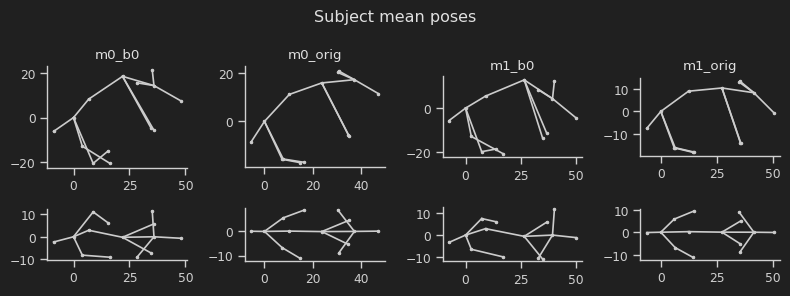

In [9]:
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
fig, ax = plt.subplots(
    2, dataset.n_sessions, figsize=(dataset.n_sessions * 2, 3)
)

for i, session in enumerate(dataset.sessions):
    viz_util.plot_mouse_views(
        ax[:, i],
        dataset.get_session(session).mean(axis=0),
        Armature.from_config(cfg["dataset"]),
        color=colors.neutral,
        specialkp=None,
    )
    ax[0, i].set_title(session)

fig.suptitle("Subject mean poses")
plotter.finalize(fig, None)

In [ ]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
    'morph.upd_var_modes': [1e-2, 1e-1, 1e2],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 30,
    'pose.init.subsample': 0.5,
})

scans.run_scan(project, "prior-scan", log_every=1)